In [140]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [141]:
df = pd.read_csv("/Users/Abhirup/Desktop/Projects/HSBC DS Assignment/PS_20174392719_1491204439457_log.csv")
df.sort_values(by=['step'])
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df_cot=df[df['type'].isin(['CASH_OUT','TRANSFER'])]
df_cot=df_cot.reset_index(drop=True)

#Since Steps are hours, make bins of observations to weeks
for i in range(4):
    df_cot.loc[(df_cot['step']>186*i) & (df_cot['step']<=186*(i+1)),'week'] =i+1
df_cot['week'].value_counts().sort_index()

1.000000     990974
2.000000    1317246
3.000000     380559
4.000000      81630
Name: week, dtype: int64

In [142]:
#Create Feature of customer's $ amount and number of transaction last week
df_cot_t1=pd.DataFrame()
for i in range(2,5):
    df_cot_lw=df_cot[df_cot['week']==i-1]
    df_cot_cw=df_cot[df_cot['week']==i]
    cust_list = df_cot_cw['nameOrig'].drop_duplicates().tolist()
    df_cot_lw_amt=df_cot_lw[df_cot_lw['nameOrig'].isin(cust_list)].groupby('nameOrig',as_index=False)['amount'].sum()
    df_cot_lw_tnum=df_cot_lw[df_cot_lw['nameOrig'].isin(cust_list)].groupby('nameOrig',as_index=False)['amount'].count()
    df_cot_lw_amt=df_cot_lw_amt.rename(columns={'amount':'$TransLW'})
    df_cot_lw_tnum=df_cot_lw_tnum.rename(columns={'amount':'NumTransLW'})
    df_cot_cw=pd.merge(df_cot_cw,pd.merge(df_cot_lw_amt,df_cot_lw_tnum,on='nameOrig'),how='left',on='nameOrig')
    df_cot_t1=df_cot_t1.append(df_cot_cw)

In [143]:
print(df_cot_t1['week'].min())
print(df_cot_t1['week'].max())

2.0
4.0


In [144]:
df_cot_fraud=df_cot_t1.groupby('week',as_index=False)['isFraud'].sum()
df_cot_fraud=df_cot_fraud.rename(columns={'isFraud':'FraudTran'})
#df_cot_fraud_cust=df_cot[df_cot['NumTransLW']>0].groupby('week',as_index=False)['isFraud'].sum()
df_cot_fraud=pd.merge(df_cot_fraud,df_cot_t1[df_cot_t1['NumTransLW']>0].groupby('week',as_index=False)['isFraud'].sum(),
                      how='left',on='week')
df_cot_fraud['fraud_perc']=round(df_cot_fraud['isFraud']/df_cot_fraud['FraudTran']*100,2)
print("\n% of weekly reapating customers transactions are fraud")
print(df_cot_fraud)


% of weekly reapating customers transactions are fraud
      week  FraudTran  isFraud  fraud_perc
0 2.000000       2031        1    0.050000
1 3.000000       2012        1    0.050000
2 4.000000       2048        0    0.000000


In [145]:
df_cot_t2=df_cot[df_cot['week']==1]
df_cot_t2['$TransLW']=0
df_cot_t2['NumTransLW']=0

df_cot=pd.DataFrame()
df_cot=df_cot_t2.append(df_cot_t1)
df_cot.sort_values(by=['step'])
df_cot=df_cot.reset_index(drop=True)
df_cot.fillna(0, inplace=True)
df_cot.shape

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(2770409, 14)

In [146]:
df_cot[df_cot['NumTransLW']>0].groupby('week')['nameOrig'].nunique()

week
2.000000    628
3.000000    210
4.000000     10
Name: nameOrig, dtype: int64

In [147]:
#Creating Flag for Destination names involved in Fraud before
df_cot_fraud=df_cot.loc[df_cot['isFraud']==1,['step','nameDest']].sort_values(by=['step','nameDest'])
df_cot_fraud=df_cot_fraud.rename(columns={'step':'fraud_step'})
print(df_cot_fraud.shape)
print(df_cot_fraud['nameDest'].nunique())

(8213, 2)
8169


In [148]:
df_cot_fraud.drop_duplicates(subset='nameDest',keep='first',inplace=True)
print(df_cot_fraud.shape)
print(df_cot_fraud['nameDest'].nunique())

(8169, 2)
8169


In [149]:
df_cot=pd.merge(df_cot,df_cot_fraud,how='left',on='nameDest')
df_cot['fraud_step'].fillna(0,inplace=True)
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,week,$TransLW,NumTransLW,fraud_step
0,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1,0,1.000000,0.000000,0.000000,1.000000
1,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1,0,1.000000,0.000000,0.000000,1.000000
2,1,CASH_OUT,229133.940000,C905080434,15325.000000,0.000000,C476402209,5083.000000,51513.440000,0,0,1.000000,0.000000,0.000000,0.000000
3,1,TRANSFER,215310.300000,C1670993182,705.000000,0.000000,C1100439041,22425.000000,0.000000,0,0,1.000000,0.000000,0.000000,0.000000
4,1,TRANSFER,311685.890000,C1984094095,10835.000000,0.000000,C932583850,6267.000000,2719172.890000,0,0,1.000000,0.000000,0.000000,4.000000


In [150]:
df_cot.loc[df_cot['fraud_step']==0,'FraudBefore']=0
df_cot.loc[(df_cot['fraud_step']<df_cot['step']) & (df_cot['fraud_step']!=0),'FraudBefore']=1
df_cot.loc[df_cot['fraud_step']>=df_cot['step'],'FraudBefore']=0
df_cot=df_cot.drop('fraud_step', axis=1)
df_cot[df_cot['FraudBefore']==1].head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,week,$TransLW,NumTransLW,FraudBefore
736,2,CASH_OUT,279843.200000,C1043535321,0.000000,0.000000,C716083600,1827318.890000,2107162.100000,0,0,1.000000,0.000000,0.000000,1.000000
870,3,CASH_OUT,14979.830000,C1613729684,25099.300000,10119.470000,C991505714,1051654.280000,1066634.100000,0,0,1.000000,0.000000,0.000000,1.000000
889,3,TRANSFER,280567.170000,C923366543,0.000000,0.000000,C667346055,9989133.640000,10670907.240000,0,0,1.000000,0.000000,0.000000,1.000000
895,3,TRANSFER,521678.460000,C954742840,0.000000,0.000000,C667346055,10269700.810000,10670907.240000,0,0,1.000000,0.000000,0.000000,1.000000
899,3,TRANSFER,708855.970000,C115297013,0.000000,0.000000,C991505714,1066634.100000,2109808.940000,0,0,1.000000,0.000000,0.000000,1.000000


In [151]:
df_cot.shape

(2770409, 15)

In [152]:
#Create old balance orig tiers
pd.set_option('float_format', '{:f}'.format)
df_cot['oldBalanceOrig'].describe()

count    2770409.000000
mean       47643.079411
std       251325.127490
min            0.000000
25%            0.000000
50%          303.960000
75%        30997.000000
max     59585040.370000
Name: oldBalanceOrig, dtype: float64

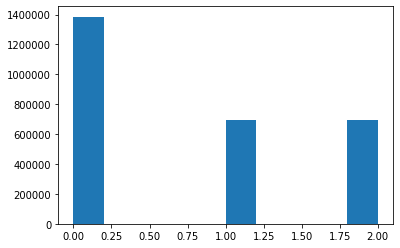

oldBalanceOrig_grp
0        303.960000
1      30997.000000
2   59585040.370000
Name: oldBalanceOrig, dtype: float64
oldBalanceOrig_grp
0       0.000000
1     304.000000
2   30998.000000
Name: oldBalanceOrig, dtype: float64


In [153]:
df_cot['oldBalanceOrig_grp']=pd.qcut(df_cot['oldBalanceOrig'], 4, labels=False, duplicates='drop')
plt.hist(df_cot['oldBalanceOrig_grp'])
plt.show()
print(df_cot.groupby('oldBalanceOrig_grp')['oldBalanceOrig'].max())
print(df_cot.groupby('oldBalanceOrig_grp')['oldBalanceOrig'].min())

In [154]:
df_cot.loc[df_cot['oldBalanceOrig']>30000,'oldBalanceOrigCat']=3
df_cot.loc[df_cot['oldBalanceOrig']<=30000,'oldBalanceOrigCat']=2
df_cot.loc[df_cot['oldBalanceOrig']<=0,'oldBalanceOrigCat']=1
df_cot=df_cot.drop('oldBalanceOrig_grp', axis=1)
print(df_cot['oldBalanceOrigCat'].value_counts())
print(df_cot.shape)

1.000000    1308582
2.000000     742656
3.000000     719171
Name: oldBalanceOrigCat, dtype: int64
(2770409, 16)


In [155]:
#Create Me vs Others Features based on Balance Category
amt_median=df_cot.groupby('oldBalanceOrigCat',as_index=False)['amount'].median()
amt_median=amt_median.rename(columns={'amount':'amount_median'})
amt_std=df_cot.groupby('oldBalanceOrigCat')[['amount','step']].std()
amt_std['oldBalanceOrigCat']=amt_std.index
amt_std=amt_std.drop('step',axis=1)
amt_std=amt_std.reset_index(drop=True)
amt_std=amt_std.rename(columns={'amount':'amount_std'})
amt_max=df_cot[df_cot['isFraud']==0].groupby('oldBalanceOrigCat',as_index=False)['amount'].max()
amt_max=amt_max.rename(columns={'amount':'amt_max'})
print(amt_median)
print(amt_std)
print(amt_max)

   oldBalanceOrigCat  amount_median
0           1.000000  168143.915000
1           2.000000  173122.360000
2           3.000000  175098.490000
      amount_std  oldBalanceOrigCat
0 1081274.092085           1.000000
1  615454.631850           2.000000
2  718753.954809           3.000000
   oldBalanceOrigCat         amt_max
0           1.000000 92445516.640000
1           2.000000 47504216.380000
2           3.000000 57787800.930000


In [156]:
#df_cot=df_cot.drop(['amount_median_x','amount_std_x','amt_max_x','amount_median_y','amount_std_y','amt_max_y'],axis=1)
#df_cot=df_cot.drop(['amount_median','amount_std','amt_max'],,axis=1)
df_cot=pd.merge(df_cot,amt_median,how='left',on='oldBalanceOrigCat')
df_cot=pd.merge(df_cot,amt_std,how='left',on='oldBalanceOrigCat')
df_cot=pd.merge(df_cot,amt_max,how='left',on='oldBalanceOrigCat')
df_cot.shape

(2770409, 19)

In [157]:
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,week,$TransLW,NumTransLW,FraudBefore,oldBalanceOrigCat,amount_median,amount_std,amt_max
0,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1,0,1.000000,0.000000,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000
1,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1,0,1.000000,0.000000,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000
2,1,CASH_OUT,229133.940000,C905080434,15325.000000,0.000000,C476402209,5083.000000,51513.440000,0,0,1.000000,0.000000,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000
3,1,TRANSFER,215310.300000,C1670993182,705.000000,0.000000,C1100439041,22425.000000,0.000000,0,0,1.000000,0.000000,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000
4,1,TRANSFER,311685.890000,C1984094095,10835.000000,0.000000,C932583850,6267.000000,2719172.890000,0,0,1.000000,0.000000,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000


In [158]:
df_cot['amount_deviance_1']=(df_cot['amount']-df_cot['amount_median'])/df_cot['amount_std']
df_cot['amount_deviance_2']=df_cot['amount']-df_cot['amount_median']
df_cot['amount_deviance_3']=df_cot['amt_max']-df_cot['amount']
df_cot['amount_deviance_4']=(df_cot['amt_max']-df_cot['amount'])/df_cot['amt_max']
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,NumTransLW,FraudBefore,oldBalanceOrigCat,amount_median,amount_std,amt_max,amount_deviance_1,amount_deviance_2,amount_deviance_3,amount_deviance_4
0,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1,...,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000,-0.280998,-172941.360000,47504035.380000,0.999996
1,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1,...,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000,-0.280998,-172941.360000,47504035.380000,0.999996
2,1,CASH_OUT,229133.940000,C905080434,15325.000000,0.000000,C476402209,5083.000000,51513.440000,0,...,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000,0.091008,56011.580000,47275082.440000,0.995177
3,1,TRANSFER,215310.300000,C1670993182,705.000000,0.000000,C1100439041,22425.000000,0.000000,0,...,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000,0.068548,42187.940000,47288906.080000,0.995468
4,1,TRANSFER,311685.890000,C1984094095,10835.000000,0.000000,C932583850,6267.000000,2719172.890000,0,...,0.000000,0.000000,2.000000,173122.360000,615454.631850,47504216.380000,0.225140,138563.530000,47192530.490000,0.993439


In [159]:
# Flag when amount =0

df_cot.loc[df_cot['amount']==0,'amount_zero']=1
df_cot.loc[df_cot['amount']!=0,'amount_zero']=0
df_cot['amount_zero'].value_counts()

0.000000    2770393
1.000000         16
Name: amount_zero, dtype: int64

In [160]:
# Amount/oldBalanceOrig

df_cot.loc[df['oldBalanceOrig']!=0,'amt_bal_perc']=round(df_cot['amount']/df_cot['oldBalanceOrig']*100,2)
df_cot.loc[df['oldBalanceOrig']==0,'amt_bal_perc']=0
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,oldBalanceOrigCat,amount_median,amount_std,amt_max,amount_deviance_1,amount_deviance_2,amount_deviance_3,amount_deviance_4,amount_zero,amt_bal_perc
0,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1,...,2.000000,173122.360000,615454.631850,47504216.380000,-0.280998,-172941.360000,47504035.380000,0.999996,0.000000,100.000000
1,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1,...,2.000000,173122.360000,615454.631850,47504216.380000,-0.280998,-172941.360000,47504035.380000,0.999996,0.000000,100.000000
2,1,CASH_OUT,229133.940000,C905080434,15325.000000,0.000000,C476402209,5083.000000,51513.440000,0,...,2.000000,173122.360000,615454.631850,47504216.380000,0.091008,56011.580000,47275082.440000,0.995177,0.000000,1495.160000
3,1,TRANSFER,215310.300000,C1670993182,705.000000,0.000000,C1100439041,22425.000000,0.000000,0,...,2.000000,173122.360000,615454.631850,47504216.380000,0.068548,42187.940000,47288906.080000,0.995468,0.000000,30540.470000
4,1,TRANSFER,311685.890000,C1984094095,10835.000000,0.000000,C932583850,6267.000000,2719172.890000,0,...,2.000000,173122.360000,615454.631850,47504216.380000,0.225140,138563.530000,47192530.490000,0.993439,0.000000,2876.660000


In [161]:
# Time of the day by splitting every 24 steps in 3 parts

for i in range (31):
    df_cot.loc[(df_cot['step']>=8+(24*i)-7)& (df_cot['step']<=8+(24*i)),'time_of_day']=1
    df_cot.loc[(df_cot['step']>=16+(24*i)-7)& (df_cot['step']<=16+(24*i)),'time_of_day']=2
    df_cot.loc[(df_cot['step']>=24+(24*i)-7)& (df_cot['step']<=24+(24*i)),'time_of_day']=3

In [162]:
print(df_cot.groupby('time_of_day')['step'].nunique())
print(df_cot.groupby('time_of_day')['step'].max())
print(df_cot.groupby('time_of_day')['step'].min())

time_of_day
1.000000    248
2.000000    248
3.000000    247
Name: step, dtype: int64
time_of_day
1.000000    728
2.000000    736
3.000000    743
Name: step, dtype: int64
time_of_day
1.000000     1
2.000000     9
3.000000    17
Name: step, dtype: int64


In [163]:
#Create Me vs Others based on Balance Category and Time of Day
amt_median=df_cot.groupby(['oldBalanceOrigCat','time_of_day'],as_index=False)['amount'].median()
amt_median=amt_median.rename(columns={'amount':'amount_tod_median'})
amt_std=df_cot.groupby(['oldBalanceOrigCat','time_of_day'])[['amount','step']].std()
amt_std['time_of_day']=amt_std.index.get_level_values('time_of_day')
amt_std['oldBalanceOrigCat']=amt_std.index.get_level_values('oldBalanceOrigCat')
amt_std=amt_std.drop('step',axis=1)
amt_std=amt_std.reset_index(drop=True)
amt_std=amt_std.rename(columns={'amount':'amount_tod_std'})
amt_max=df_cot[df_cot['isFraud']==0].groupby(['oldBalanceOrigCat','time_of_day'],as_index=False)['amount'].max()
amt_max=amt_max.rename(columns={'amount':'amount_tod_max'})
print(amt_median)
print(amt_std)
print(amt_max)

   oldBalanceOrigCat  time_of_day  amount_tod_median
0           1.000000     1.000000      182980.165000
1           1.000000     2.000000      170941.910000
2           1.000000     3.000000      164472.240000
3           2.000000     1.000000      156986.250000
4           2.000000     2.000000      202427.720000
5           2.000000     3.000000      143976.790000
6           3.000000     1.000000      234689.590000
7           3.000000     2.000000      204623.985000
8           3.000000     3.000000      144726.220000
   amount_tod_std  time_of_day  oldBalanceOrigCat
0   776674.801270     1.000000           1.000000
1  1216366.153472     2.000000           1.000000
2   894563.024866     3.000000           1.000000
3   375750.012076     1.000000           2.000000
4   721949.152574     2.000000           2.000000
5   437971.368358     3.000000           2.000000
6  1565305.843495     1.000000           3.000000
7   819525.208260     2.000000           3.000000
8   509970.287083   

In [164]:
df_cot=pd.merge(df_cot,amt_median,how='left',on=['oldBalanceOrigCat','time_of_day'])
df_cot=pd.merge(df_cot,amt_std,how='left',on=['oldBalanceOrigCat','time_of_day'])
df_cot=pd.merge(df_cot,amt_max,how='left',on=['oldBalanceOrigCat','time_of_day'])
df_cot.shape

(2770409, 29)

In [165]:
df_cot['amount_deviance_5']=(df_cot['amount']-df_cot['amount_tod_median'])/df_cot['amount_tod_std']
df_cot['amount_deviance_6']=df_cot['amount']-df_cot['amount_tod_median']
df_cot['amount_deviance_7']=df_cot['amount_tod_max']-df_cot['amount']
df_cot['amount_deviance_8']=(df_cot['amount_tod_max']-df_cot['amount'])/df_cot['amount_tod_max']
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,amount_zero,amt_bal_perc,time_of_day,amount_tod_median,amount_tod_std,amount_tod_max,amount_deviance_5,amount_deviance_6,amount_deviance_7,amount_deviance_8
0,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1,...,0.000000,100.000000,1.000000,156986.250000,375750.012076,4407884.050000,-0.417313,-156805.250000,4407703.050000,0.999959
1,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1,...,0.000000,100.000000,1.000000,156986.250000,375750.012076,4407884.050000,-0.417313,-156805.250000,4407703.050000,0.999959
2,1,CASH_OUT,229133.940000,C905080434,15325.000000,0.000000,C476402209,5083.000000,51513.440000,0,...,0.000000,1495.160000,1.000000,156986.250000,375750.012076,4407884.050000,0.192010,72147.690000,4178750.110000,0.948017
3,1,TRANSFER,215310.300000,C1670993182,705.000000,0.000000,C1100439041,22425.000000,0.000000,0,...,0.000000,30540.470000,1.000000,156986.250000,375750.012076,4407884.050000,0.155220,58324.050000,4192573.750000,0.951153
4,1,TRANSFER,311685.890000,C1984094095,10835.000000,0.000000,C932583850,6267.000000,2719172.890000,0,...,0.000000,2876.660000,1.000000,156986.250000,375750.012076,4407884.050000,0.411709,154699.640000,4096198.160000,0.929289


In [167]:
df_cot.dtypes

step                   int64
type                  object
amount               float64
nameOrig              object
oldBalanceOrig       float64
newBalanceOrig       float64
nameDest              object
oldBalanceDest       float64
newBalanceDest       float64
isFraud                int64
isFlaggedFraud         int64
week                 float64
$TransLW             float64
NumTransLW           float64
FraudBefore          float64
oldBalanceOrigCat    float64
amount_median        float64
amount_std           float64
amt_max              float64
amount_deviance_1    float64
amount_deviance_2    float64
amount_deviance_3    float64
amount_deviance_4    float64
amount_zero          float64
amt_bal_perc         float64
time_of_day          float64
amount_tod_median    float64
amount_tod_std       float64
amount_tod_max       float64
amount_deviance_5    float64
amount_deviance_6    float64
amount_deviance_7    float64
amount_deviance_8    float64
dtype: object

In [170]:
for col in ['week','NumTransLW','FraudBefore','oldBalanceOrigCat','amount_zero','time_of_day']:
    df_cot[col]=df_cot[col].astype(int)
df_cot.dtypes

step                   int64
type                  object
amount               float64
nameOrig              object
oldBalanceOrig       float64
newBalanceOrig       float64
nameDest              object
oldBalanceDest       float64
newBalanceDest       float64
isFraud                int64
isFlaggedFraud         int64
week                   int64
$TransLW             float64
NumTransLW             int64
FraudBefore            int64
oldBalanceOrigCat      int64
amount_median        float64
amount_std           float64
amt_max              float64
amount_deviance_1    float64
amount_deviance_2    float64
amount_deviance_3    float64
amount_deviance_4    float64
amount_zero            int64
amt_bal_perc         float64
time_of_day            int64
amount_tod_median    float64
amount_tod_std       float64
amount_tod_max       float64
amount_deviance_5    float64
amount_deviance_6    float64
amount_deviance_7    float64
amount_deviance_8    float64
dtype: object

In [171]:
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,amount_zero,amt_bal_perc,time_of_day,amount_tod_median,amount_tod_std,amount_tod_max,amount_deviance_5,amount_deviance_6,amount_deviance_7,amount_deviance_8
0,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1,...,0,100.000000,1,156986.250000,375750.012076,4407884.050000,-0.417313,-156805.250000,4407703.050000,0.999959
1,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1,...,0,100.000000,1,156986.250000,375750.012076,4407884.050000,-0.417313,-156805.250000,4407703.050000,0.999959
2,1,CASH_OUT,229133.940000,C905080434,15325.000000,0.000000,C476402209,5083.000000,51513.440000,0,...,0,1495.160000,1,156986.250000,375750.012076,4407884.050000,0.192010,72147.690000,4178750.110000,0.948017
3,1,TRANSFER,215310.300000,C1670993182,705.000000,0.000000,C1100439041,22425.000000,0.000000,0,...,0,30540.470000,1,156986.250000,375750.012076,4407884.050000,0.155220,58324.050000,4192573.750000,0.951153
4,1,TRANSFER,311685.890000,C1984094095,10835.000000,0.000000,C932583850,6267.000000,2719172.890000,0,...,0,2876.660000,1,156986.250000,375750.012076,4407884.050000,0.411709,154699.640000,4096198.160000,0.929289


In [173]:
df_cot['diffBalanceOrig'] = df_cot['newBalanceOrig'] + df_cot['amount'] - df_cot['oldBalanceOrig']
df_cot['diffBalanceDest'] = df_cot['oldBalanceDest'] + df_cot['amount'] - df_cot['newBalanceDest']
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,time_of_day,amount_tod_median,amount_tod_std,amount_tod_max,amount_deviance_5,amount_deviance_6,amount_deviance_7,amount_deviance_8,diffBalanceOrig,diffBalanceDest
0,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1,...,1,156986.250000,375750.012076,4407884.050000,-0.417313,-156805.250000,4407703.050000,0.999959,0.000000,181.000000
1,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1,...,1,156986.250000,375750.012076,4407884.050000,-0.417313,-156805.250000,4407703.050000,0.999959,0.000000,21363.000000
2,1,CASH_OUT,229133.940000,C905080434,15325.000000,0.000000,C476402209,5083.000000,51513.440000,0,...,1,156986.250000,375750.012076,4407884.050000,0.192010,72147.690000,4178750.110000,0.948017,213808.940000,182703.500000
3,1,TRANSFER,215310.300000,C1670993182,705.000000,0.000000,C1100439041,22425.000000,0.000000,0,...,1,156986.250000,375750.012076,4407884.050000,0.155220,58324.050000,4192573.750000,0.951153,214605.300000,237735.300000
4,1,TRANSFER,311685.890000,C1984094095,10835.000000,0.000000,C932583850,6267.000000,2719172.890000,0,...,1,156986.250000,375750.012076,4407884.050000,0.411709,154699.640000,4096198.160000,0.929289,300850.890000,-2401220.000000


In [177]:
#df_cot.dtypes
for col in ['amount','oldBalanceOrig','newBalanceOrig','oldBalanceDest','newBalanceDest','$TransLW','amount_median'
            ,'amount_std','amt_max','amount_deviance_1','amount_deviance_2','amount_deviance_3','amount_deviance_4'
            ,'amt_bal_perc','amount_tod_median','amount_tod_std','amount_tod_max','amount_deviance_5'
            ,'amount_deviance_6','amount_deviance_7','amount_deviance_8','diffBalanceOrig','diffBalanceDest']:
    df_cot[col]=round(df_cot[col],2)
df_cot.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,time_of_day,amount_tod_median,amount_tod_std,amount_tod_max,amount_deviance_5,amount_deviance_6,amount_deviance_7,amount_deviance_8,diffBalanceOrig,diffBalanceDest
0,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,1,...,1,156986.250000,375750.010000,4407884.050000,-0.420000,-156805.250000,4407703.050000,1.000000,0.000000,181.000000
1,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,1,...,1,156986.250000,375750.010000,4407884.050000,-0.420000,-156805.250000,4407703.050000,1.000000,0.000000,21363.000000
2,1,CASH_OUT,229133.940000,C905080434,15325.000000,0.000000,C476402209,5083.000000,51513.440000,0,...,1,156986.250000,375750.010000,4407884.050000,0.190000,72147.690000,4178750.110000,0.950000,213808.940000,182703.500000
3,1,TRANSFER,215310.300000,C1670993182,705.000000,0.000000,C1100439041,22425.000000,0.000000,0,...,1,156986.250000,375750.010000,4407884.050000,0.160000,58324.050000,4192573.750000,0.950000,214605.300000,237735.300000
4,1,TRANSFER,311685.890000,C1984094095,10835.000000,0.000000,C932583850,6267.000000,2719172.890000,0,...,1,156986.250000,375750.010000,4407884.050000,0.410000,154699.640000,4096198.160000,0.930000,300850.890000,-2401220.000000


In [178]:
df_cot.to_csv('/Users/Abhirup/Desktop/Projects/HSBC DS Assignment/df_cot.csv', index=False)